In [1]:
import os
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Loading Data

In [2]:
DATA_PATH = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data/toy_data.csv")

In [3]:
df = pd.read_csv(DATA_PATH)

In [4]:
cols_raw = list(df.columns)
cols_trash = ['Unnamed: 0', 'converged']
cols_independent = ['accuracy']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)


In [5]:
X_raw = df[cols_dependent]
y_raw = df[cols_independent]

# Train-Test-Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.1,
    random_state=42)

# Pipeline Definition

## Linear Model with polynomial feature augmentation

In [7]:
#DEFINITION OF PREPROCESSING STEPS
scaler = StandardScaler()
poly_augmentation = PolynomialFeatures(degree=3)

In [8]:
#DEFINITION OF REGRESSOR
linear_regressor = LinearRegression()
#regressor = GradientBoostingRegressor

In [9]:
#COMBINING EVERYTHING TO A PIPELINE
simple_model = Pipeline([
    ('poly', poly_augmentation),
    ('scaler', scaler),
    ('regressor', linear_regressor)
])

In [10]:
simple_model.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [11]:
mse_test = mean_squared_error(y_test, simple_model.predict(X_test))
mse_train = mean_squared_error(y_train, simple_model.predict(X_train))
print(f"MSE:\ttrain:{mse_train}\ttest:{mse_test}")

MSE:	train:7.16540097611912e-26	test:8.963721601237086e-26


In [12]:
mape_test = mean_absolute_percentage_error(y_test, simple_model.predict(X_test))
mape_train = mean_absolute_percentage_error(y_train, simple_model.predict(X_train))
print(f"MAPE:\ttrain:{mape_train}\ttest:{mape_test}")

MAPE:	train:1.65603396253376	test:5.615490796374145


## Random Forest

In [13]:
rf_regressor = RandomForestRegressor()
rf_model = Pipeline([
    ('poly', poly_augmentation),
    ('scaler', scaler),
    ('regressor', rf_regressor)
])

In [14]:
rf_model.fit(X_train, y_train)

/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor())])

In [15]:
mse_test = mean_squared_error(y_test, rf_model.predict(X_test))
mse_train = mean_squared_error(y_train, rf_model.predict(X_train))
print(f"MSE:\ttrain:{mse_train}\ttest:{mse_test}")

MSE:	train:3.8593104998062044e-27	test:3.9656066277586197e-26


In [16]:
mape_test = mean_absolute_percentage_error(y_test, rf_model.predict(X_test))
mape_train = mean_absolute_percentage_error(y_train, rf_model.predict(X_train))
print(f"MAPE:\ttrain:{mape_train}\ttest:{mape_test}")

MAPE:	train:0.276652153621372	test:3.7234370984808685


# Visualization

In [17]:
for a, b in zip(y_test["accuracy"], simple_model.predict(X_test)):
    print(f"{a:.2E}\t{float(b):.2E}")

8.40E-13	3.83E-13
4.50E-13	5.79E-13
8.00E-14	2.93E-13
2.70E-13	2.26E-13
3.90E-13	3.52E-13
8.80E-13	3.41E-13
8.10E-13	4.12E-13
6.20E-13	5.30E-13
5.10E-13	3.19E-13
9.50E-13	3.69E-13
6.80E-13	2.03E-13
8.70E-13	3.22E-13
1.10E-13	2.37E-13
6.90E-13	4.11E-13
1.80E-13	1.30E-13
9.80E-13	4.64E-13
3.70E-13	4.30E-13
2.00E-13	4.17E-13
2.10E-13	3.65E-13
4.50E-13	4.09E-13
3.90E-13	5.24E-13
3.50E-13	4.53E-13
6.20E-13	3.49E-13
2.10E-13	2.75E-13
9.10E-13	3.69E-13
8.50E-13	4.23E-13
5.00E-13	4.07E-13
6.40E-13	3.64E-13
1.80E-13	3.03E-13
5.60E-13	5.55E-13
2.80E-13	2.50E-13
2.90E-13	4.23E-13
3.20E-13	3.61E-13
1.80E-13	1.12E-13
1.50E-13	4.42E-13
4.40E-13	6.05E-13
6.90E-14	7.23E-13
1.50E-13	4.60E-13
1.60E-15	4.14E-13
7.70E-13	5.20E-13
3.30E-14	4.09E-13
7.80E-13	4.23E-13
6.00E-13	4.05E-13
9.30E-14	3.38E-13
5.00E-13	4.16E-13
4.40E-14	4.12E-13
1.20E-13	2.52E-13
1.30E-13	1.23E-13
1.40E-13	4.15E-13
6.80E-13	3.98E-13
2.10E-13	2.70E-13
1.90E-13	6.86E-13
9.50E-13	3.93E-13
1.90E-13	4.40E-13
1.80E-13	4.01E-13
7.10E-13	4

In [18]:
for a, b in zip(y_test["accuracy"], rf_model.predict(X_test)):
    print(f"{a:.2E}\t{b:.2E}")

8.40E-13	6.65E-13
4.50E-13	4.60E-13
8.00E-14	1.46E-13
2.70E-13	2.75E-13
3.90E-13	3.99E-13
8.80E-13	2.21E-13
8.10E-13	7.60E-13
6.20E-13	6.52E-13
5.10E-13	3.07E-13
9.50E-13	9.23E-13
6.80E-13	3.00E-13
8.70E-13	4.42E-13
1.10E-13	1.21E-13
6.90E-13	4.45E-13
1.80E-13	2.05E-13
9.80E-13	2.92E-13
3.70E-13	3.87E-13
2.00E-13	4.80E-13
2.10E-13	2.96E-13
4.50E-13	7.60E-13
3.90E-13	4.79E-13
3.50E-13	2.55E-13
6.20E-13	4.10E-13
2.10E-13	2.06E-13
9.10E-13	7.61E-13
8.50E-13	7.30E-13
5.00E-13	4.29E-13
6.40E-13	6.24E-13
1.80E-13	4.98E-13
5.60E-13	5.24E-13
2.80E-13	2.12E-13
2.90E-13	6.04E-13
3.20E-13	3.58E-13
1.80E-13	1.90E-13
1.50E-13	1.65E-13
4.40E-13	4.47E-13
6.90E-14	3.52E-13
1.50E-13	1.60E-13
1.60E-15	3.02E-13
7.70E-13	7.92E-13
3.30E-14	1.58E-13
7.80E-13	7.67E-13
6.00E-13	4.41E-13
9.30E-14	2.35E-13
5.00E-13	6.71E-13
4.40E-14	9.99E-14
1.20E-13	1.26E-13
1.30E-13	1.69E-13
1.40E-13	2.20E-13
6.80E-13	4.95E-13
2.10E-13	2.48E-13
1.90E-13	3.19E-13
9.50E-13	8.43E-13
1.90E-13	2.02E-13
1.80E-13	2.74E-13
7.10E-13	5

In [19]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'ecutwfc')

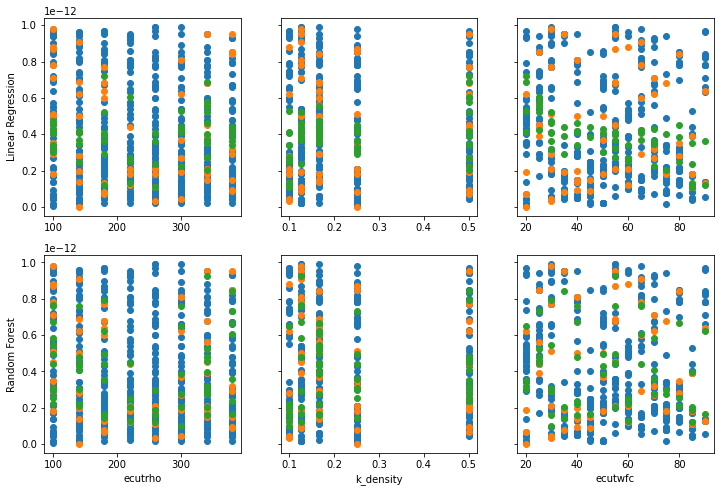

In [20]:
fig, ax = plt.subplots(2,3,figsize=(12,8), sharey=True)
models = [simple_model, rf_model]
for j, model in enumerate(models):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
ax[0,0].set_ylabel("Linear Regression")
ax[1,0].set_ylabel("Random Forest")
ax[1,0].set_xlabel("ecutrho")
ax[1,1].set_xlabel('k_density')
ax[1,2].set_xlabel('ecutwfc')